# **Step 1: Setting up Google Colab**

In [1]:
!pip install -U keras-tuner

     |████████████████████████████████| 98 kB 3.1 MB/s 


This will install PyDrive. Now we will import a few required libraries:

In [2]:
!pip install PyDrive

Next, we will create a drive variable to access Google Drive:

In [3]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

To download the dataset, we will use the ID of the file uploaded on Google Drive:

In [5]:
download = drive.CreateFile({'id': '1qNeafUZZ8QnMnJcdac45XHXcWBtYUX6X'})

In [6]:
download.GetContentFile('train_LbELtWX.zip')
!unzip train_LbELtWX.zip

Archive:  train_LbELtWX.zip
   creating: train_LbELtWX/images/
   creating: train_LbELtWX/images/images/
  inflating: train_LbELtWX/images/images/1.jpg  
  inflating: train_LbELtWX/images/images/10.jpg  
  inflating: train_LbELtWX/images/images/100.jpg  
  inflating: train_LbELtWX/images/images/1000.jpg  
  inflating: train_LbELtWX/images/images/1001.jpg  
  inflating: train_LbELtWX/images/images/1002.jpg  
  inflating: train_LbELtWX/images/images/1003.jpg  
  inflating: train_LbELtWX/images/images/1004.jpg  
  inflating: train_LbELtWX/images/images/1005.jpg  
  inflating: train_LbELtWX/images/images/1006.jpg  
  inflating: train_LbELtWX/images/images/1007.jpg  
  inflating: train_LbELtWX/images/images/1008.jpg  
  inflating: train_LbELtWX/images/images/1009.jpg  
  inflating: train_LbELtWX/images/images/101.jpg  
  inflating: train_LbELtWX/images/images/1010.jpg  
  inflating: train_LbELtWX/images/images/1011.jpg  
  inflating: train_LbELtWX/images/images/1012.jpg  
  inflating: train

# **Step 2 : Import the libraries we’ll need during our model building phase.**

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical
from tqdm import tqdm

# **Step 3: Loading the data**

In [8]:
train = pd.read_csv('train_LbELtWX/train.csv')

In [9]:
train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,...,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,0.013672,0.019531,0.066406,0.000000,0.029297,0.0,0.031250,0.011719,0.000000,0.025391,0.023438,0.001953,0.0,0.015625,0.000000,0.031250,0.000000,0.013672,0.029297,0.015625,0.011719,0.003906,0.025391,0.000000,0.001953,0.011719,0.009766,0.041016,...,0.008789,0.015625,0.044922,0.000000,0.037109,0.012695,0.028320,0.000000,0.019531,0.026367,0.005859,0.0,0.004883,0.016602,0.034180,0.056641,0.006836,0.000977,0.022461,0.037109,0.004883,0.021484,0.035156,0.000977,0.004883,0.015625,0.000000,0.0,0.006836,0.037109,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,0.003906,0.027344,0.023438,0.000000,0.033203,0.0,0.009766,0.009766,0.007812,0.007812,0.019531,0.007812,0.0,0.000000,0.007812,0.027344,0.003906,0.037109,0.007812,0.048828,0.054688,0.027344,0.003906,0.000000,0.000000,0.003906,0.013672,0.033203,...,0.050781,0.001953,0.021484,0.003906,0.027344,0.023438,0.062500,0.000000,0.038086,0.000000,0.019531,0.0,0.001953,0.003906,0.015625,0.004883,0.104490,0.000000,0.061523,0.007812,0.008789,0.013672,0.011719,0.001953,0.035156,0.007812,0.000000,0.0,0.053711,0.036133,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,0.007812,0.011719,0.021484,0.001953,0.025391,0.0,0.009766,0.011719,0.007812,0.005859,0.041016,0.001953,0.0,0.015625,0.000000,0.009766,0.001953,0.009766,0.009766,0.015625,0.005859,0.000000,0.017578,0.007812,0.005859,0.009766,0.019531,0.042969,...,0.000977,0.000000,0.000977,0.003906,0.035156,0.015625,0.027344,0.000000,0.000000,0.008789,0.015625,0.0,0.000000,0.011719,0.000977,0.000977,0.000000,0.000000,0.000000,0.005859,0.022461,0.020508,0.021484,0.056641,0.010742,0.008789,0.000000,0.0,0.000977,0.000000,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,0.001953,0.019531,0.001953,0.003906,0.035156,0.0,0.005859,0.000000,0.001953,0.003906,0.039062,0.009766,0.0,0.009766,0.005859,0.027344,0.001953,0.017578,0.003906,0.021484,0.027344,0.027344,0.000000,0.003906,0.011719,0.003906,0.005859,0.044922,...,0.005859,0.019531,0.124020,0.000000,0.017578,0.000977,0.016602,0.009766,0.006836,0.000977,0.005859,0.0,0.000977,0.001953,0.096680,0.016602,0.126950,0.000000,0.036133,0.055664,0.000000,0.001953,0.027344,0.000000,0.006836,0.017578,0.004883,0.0,0.006836,0.022461,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,0.001953,0.044922,0.041016,0.011719,0.041016,0.0,0.009766,0.015625,0.011719,0.007812,0.021484,0.000000,0.0,0.000000,0.015625,0.009766,0.001953,0.017578,0.041016,0.005859,0.021484,0.013672,0.017578,0.000000,0.005859,0.009766,0.027344,0.083984,...,0.000000,0.000000,0.040039,0.005859,0.005859,0.000000,0.003906,0.000000,0.000000,0.110350,0.000000,0.0,0.000000,0.087891,0.023

Next, we will read all the training images, store them in a list, and finally convert that list into a numpy array.

In [10]:
# We have grayscale images, so while loading the images we will keep grayscale=True, if you have RGB images, you should set grayscale as False
train_image = []
for i in tqdm(range(train.shape[0])):
    #img = image.load_img("https://drive.google.com/file/d/15T1yuZwsU1YRu0nHmJQGvsMnvYjM01EJ/view?usp=sharing")
    img = image.load_img('train_LbELtWX/images/images/'+ train['id'][i].astype('str')+'.jpg', target_size=(32,32,1), grayscale=True)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

  0%|          | 0/990 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 990/990 [00:01<00:00, 687.43it/s]


As it is a multi-class classification problem (99 classes), we will one-hot encode the target variable.

In [11]:
# Creating the target variable
y=train['species'].values
y = LabelEncoder().fit(y).transform(y)
y = to_categorical(y)
print(y.shape)

(990, 99)


# **Step 4: Creating a validation set from the training data.**

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [19]:
def hypertuning_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=32),kernel_size=hp.Choice('conv_1_kernel',values = [3,5]),
                                                  activation='relu',
                                                  input_shape=(32,32,1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(keras.layers.Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.5,default=0.25,step=0.05,)))

  model.add(keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),kernel_size=hp.Choice('conv_2_kernel',values = [3,5]),activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(keras.layers.Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.5,default=0.25,step=0.05,)))
 
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=hp.Int('dense_1_units',min_value=32,max_value=128, step=32),activation='relu'))
  model.add(keras.layers.Dense(99,activation='relu'))
  model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
  return model

In [20]:
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

tuner = kt.BayesianOptimization(
    hypertuning_model,
    max_trials=5,
    objective='val_accuracy'
  
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [21]:
#create a callback to stop training early after reaching a certain value for the validation loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [22]:
tuner.search(
  X_train, y_train,
  epochs=20,
  batch_size=32,
  validation_data=(X_test, y_test)
)
#get the most efficient hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=2)
print(f"""
The best Conv_1_filter is {best_hp.get("conv_1_filter")},
The best Conv_2_filter is {best_hp.get("conv_2_filter")},
The best conv_1_kernel is {best_hp.get("conv_1_kernel")},
The best conv_1_kernel is {best_hp.get("conv_2_kernel")},
The best dropout_1 is {best_hp.get("dropout_1")},
The best dropout_1 is {best_hp.get("dropout_2")},
The best dense_1_units is {best_hp.get("dense_1_units")}

""")

Trial 6 Complete [00h 00m 08s]
val_accuracy: 0.18686868250370026

Best val_accuracy So Far: 0.18686868250370026
Total elapsed time: 00h 01m 13s
INFO:tensorflow:Oracle triggered exit

The best Conv_1_filter is 112,
The best Conv_2_filter is 128,
The best conv_1_kernel is 3,
The best conv_1_kernel is 3,
The best dropout_1 is 0.0,
The best dropout_1 is 0.5,
The best dense_1_units is 128




# **Step 5: Define the model structure.**

In [23]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5),activation='relu',input_shape=(32,32,1)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(99, activation='softmax'))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 128)       32896     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                  

Next, we will compile the model we’ve created.

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

# **Step 6: Training the model.**

In [26]:
history = model.fit(X, y, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
31/31 [==============================] - 2s 26ms/step - loss: 4.6072 - accuracy: 0.0061 - val_loss: 4.5927 - val_accuracy: 0.0101
Epoch 2/30
31/31 [==============================] - 0s 12ms/step - loss: 4.5273 - accuracy: 0.0141 - val_loss: 4.2879 - val_accuracy: 0.0404
Epoch 3/30
31/31 [==============================] - 0s 14ms/step - loss: 3.9752 - accuracy: 0.0889 - val_loss: 3.5269 - val_accuracy: 0.1515
Epoch 4/30
31/31 [==============================] - 0s 13ms/step - loss: 3.3011 - accuracy: 0.2111 - val_loss: 2.7194 - val_accuracy: 0.3030
Epoch 5/30
31/31 [==============================] - 0s 12ms/step - loss: 2.6541 - accuracy: 0.3040 - val_loss: 2.1589 - val_accuracy: 0.4394
Epoch 6/30
31/31 [==============================] - 0s 13ms/step - loss: 2.3340 - accuracy: 0.3848 - val_loss: 1.8920 - val_accuracy: 0.4545
Epoch 7/30
31/31 [==============================] - 0s 12ms/step - loss: 2.0425 - accuracy: 0.4364 - val_loss: 1.5925 - val_accuracy: 0.5505
Epoch 8/30
31

In [27]:
print('val_acc: ',max(history.history['val_accuracy']))
print('val_loss: ',min(history.history['val_loss']))
print('train_acc: ',max(history.history['accuracy']))
print('train_loss: ',min(history.history['loss']))

print()
print("train/val loss ratio: ", min(history.history['loss'])/min(history.history['val_loss']))

val_acc:  0.9949495196342468
val_loss:  0.08300779014825821
train_acc:  0.8868687152862549
train_loss:  0.33664053678512573

train/val loss ratio:  4.055529441078484


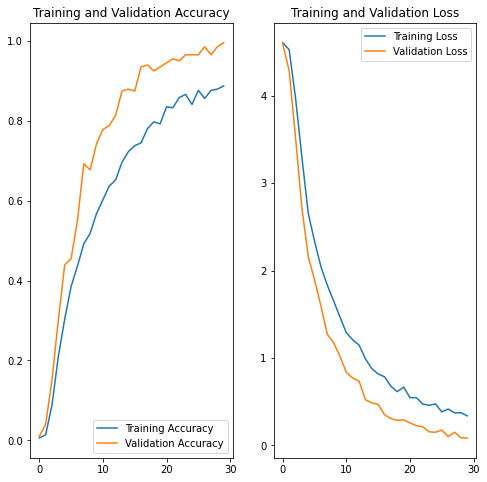

In [28]:
import matplotlib.pyplot as plt
epochs=30
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Step 7: Making predictions**

In [29]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [30]:
download = drive.CreateFile({'id': '1WnMd3JhOVfboobF22mlHkAJKCM5w_YLD'})
download.GetContentFile('test_data.zip')
!unzip test_data.zip

Archive:  test_data.zip
   creating: test_data/images/
   creating: test_data/images/images/
  inflating: test_data/images/images/1.jpg  
  inflating: test_data/images/images/10.jpg  
  inflating: test_data/images/images/100.jpg  
  inflating: test_data/images/images/1000.jpg  
  inflating: test_data/images/images/1001.jpg  
  inflating: test_data/images/images/1002.jpg  
  inflating: test_data/images/images/1003.jpg  
  inflating: test_data/images/images/1004.jpg  
  inflating: test_data/images/images/1005.jpg  
  inflating: test_data/images/images/1006.jpg  
  inflating: test_data/images/images/1007.jpg  
  inflating: test_data/images/images/1008.jpg  
  inflating: test_data/images/images/1009.jpg  
  inflating: test_data/images/images/101.jpg  
  inflating: test_data/images/images/1010.jpg  
  inflating: test_data/images/images/1011.jpg  
  inflating: test_data/images/images/1012.jpg  
  inflating: test_data/images/images/1013.jpg  
  inflating: test_data/images/images/1014.jpg  
  

In [31]:
test = pd.read_csv('test_data/test.csv')

In [32]:
test.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,margin11,margin12,margin13,margin14,margin15,margin16,margin17,margin18,margin19,margin20,margin21,margin22,margin23,margin24,margin25,margin26,margin27,margin28,margin29,margin30,margin31,margin32,margin33,margin34,margin35,margin36,margin37,margin38,margin39,...,texture25,texture26,texture27,texture28,texture29,texture30,texture31,texture32,texture33,texture34,texture35,texture36,texture37,texture38,texture39,texture40,texture41,texture42,texture43,texture44,texture45,texture46,texture47,texture48,texture49,texture50,texture51,texture52,texture53,texture54,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,0.023438,0.005859,0.021484,0.076172,0.001953,0.035156,0.000000,0.001953,0.021484,0.001953,0.015625,0.009766,0.000000,0.000000,0.005859,0.007812,0.015625,0.000000,0.017578,0.029297,0.021484,0.001953,0.003906,0.025391,0.000000,0.013672,0.005859,0.042969,0.064453,0.031250,...,0.004883,0.000000,0.013672,0.001953,0.045898,0.024414,0.045898,0.000000,0.000000,0.070312,0.011719,0.000000,0.000000,0.054688,0.024414,0.026367,0.000000,0.000977,0.010742,0.020508,0.013672,0.034180,0.025391,0.000000,0.014648,0.018555,0.000000,0.000000,0.000000,0.015625,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,0.023438,0.009766,0.019531,0.039062,0.027344,0.017578,0.000000,0.017578,0.015625,0.009766,0.009766,0.042969,0.007812,0.000000,0.003906,0.005859,0.011719,0.007812,0.009766,0.037109,0.013672,0.005859,0.003906,0.019531,0.000000,0.005859,0.029297,0.019531,0.041016,0.005859,...,0.001953,0.002930,0.051758,0.001953,0.016602,0.010742,0.044922,0.000000,0.000000,0.033203,0.013672,0.000000,0.000000,0.031250,0.058594,0.041016,0.012695,0.005859,0.021484,0.047852,0.030273,0.009766,0.041992,0.000000,0.007812,0.004883,0.000000,0.000000,0.000000,0.049805,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,0.005859,0.001953,0.021484,0.001953,0.019531,0.035156,0.000000,0.007812,0.001953,0.046875,0.003906,0.003906,0.013672,0.015625,0.037109,0.027344,0.009766,0.023438,0.027344,0.005859,0.011719,0.046875,0.056641,0.001953,0.003906,0.003906,0.005859,0.001953,0.003906,0.013672,...,0.000000,0.010742,0.010742,0.000000,0.005859,0.000000,0.088867,0.000000,0.000977,0.051758,0.000000,0.000000,0.000000,0.042969,0.002930,0.026367,0.000000,0.000000,0.000000,0.013672,0.003906,0.022461,0.007812,0.038086,0.000000,0.000000,0.000000,0.000000,0.000000,0.084961,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,0.001953,0.000000,0.029297,0.000000,0.039062,0.037109,0.003906,0.007812,0.005859,0.007812,0.005859,0.025391,0.023438,0.015625,0.021484,0.033203,0.009766,0.050781,0.015625,0.005859,0.005859,0.009766,0.015625,0.001953,0.003906,0.001953,0.005859,0.001953,0.039062,0.027344,...,0.000977,0.063477,0.013672,0.000000,0.003906,0.005859,0.000977,0.022461,0.006836,0.026367,0.000000,0.040039,0.009766,0.026367,0.016602,0.017578,0.000000,0.005859,0.018555,0.011719,0.000977,0.010742,0.025391,0.000000,0.019531,0.004883,0.077148,0.036133,0.037109,0.040039,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,0.000000,0.001953,0.033203,0.000000,0.003906,0.011719,0.000000,0.003906,0.005859,0.011719,0.001953,0.035156,0.027344,0.000000,0.003906,0.056641,0.013672,0.029297,0.023438,0.000000,0.013672,0.074219,0.083984,0.009766,0.000000,0.000000,0.001953,0.007812,0.031250,0.009766,...,0.014648,0.017578,0.000977,0.002930,0.034180,0.010742,0.031250,0.052734,0.0009

In [33]:
test_image = []
for i in tqdm(range(test.shape[0])):
    img = image.load_img('test_data/images/images/'+test['id'][i].astype('str')+'.jpg', target_size=(32,32,1), grayscale=True)
    img = image.img_to_array(img)
    #img = img/255
    test_image.append(img)
test = np.array(test_image)

  0%|          | 0/594 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 594/594 [00:00<00:00, 684.92it/s]


In [34]:
prediction = np.argmax(model.predict(test), axis=-1)

In [35]:
download = drive.CreateFile({'id': '1KLzBmAwr8j2LZ2dhd-iwXFES2XykZF1Y'})
download.GetContentFile('sample_submission.csv')

In [36]:
# creating submission file
sample = pd.read_csv('sample_submission.csv')
sample['species'] = prediction
sample.to_csv('sample_cnn.csv', header=True, index=False)

In [37]:
results=pd.read_csv('sample_cnn.csv')

In [38]:
results.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,Alnus_Cordata,Alnus_Maximowiczii,Alnus_Rubra,Alnus_Sieboldiana,Alnus_Viridis,Arundinaria_Simonii,Betula_Austrosinensis,Betula_Pendula,Callicarpa_Bodinieri,Castanea_Sativa,Celtis_Koraiensis,Cercis_Siliquastrum,Cornus_Chinensis,Cornus_Controversa,Cornus_Macrophylla,Cotinus_Coggygria,Crataegus_Monogyna,Cytisus_Battandieri,Eucalyptus_Glaucescens,Eucalyptus_Neglecta,Eucalyptus_Urnigera,Fagus_Sylvatica,Ginkgo_Biloba,Ilex_Aquifolium,Ilex_Cornuta,Liquidambar_Styraciflua,Liriodendron_Tulipifera,Lithocarpus_Cleistocarpus,Lithocarpus_Edulis,...,Quercus_Crassifolia,Quercus_Crassipes,Quercus_Dolicholepis,Quercus_Ellipsoidalis,Quercus_Greggii,Quercus_Hartwissiana,Quercus_Ilex,Quercus_Imbricaria,Quercus_Infectoria_sub,Quercus_Kewensis,Quercus_Nigra,Quercus_Palustris,Quercus_Phellos,Quercus_Phillyraeoides,Quercus_Pontica,Quercus_Pubescens,Quercus_Pyrenaica,Quercus_Rhysophylla,Quercus_Rubra,Quercus_Semecarpifolia,Quercus_Shumardii,Quercus_Suber,Quercus_Texana,Quercus_Trojana,Quercus_Variabilis,Quercus_Vulcanica,Quercus_x_Hispanica,Quercus_x_Turneri,Rhododendron_x_Russellianum,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata,species
0,4,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,12
1,7,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,53
2,9,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,1
3,12,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010